In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata

# Load in data - TOA Control

In [2]:
cat = pd.read_csv('/data/keeling/a/cristi/a/esm_data/cmip6_catalog.csv')
cat

,activity_id,branch_method,branch_time_in_child,branch_time_in_parent,experiment,experiment_id,frequency,grid,grid_label,institution_id,...,standard_name,long_name,units,vertical_levels,init_year,start_time,end_time,time_range,path,version
0,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_latent_heat_flux,Surface Upward Latent Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
1,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_sensible_heat_flux,Surface Upward Sensible Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
2,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_downwelling_longwave_flux_in_air,Surface Downwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
3,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upwelling_longwave_flux_in_air,Surface Upwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
4,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,toa_outgoing_longwave_flux,TOA Outgoing Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_downwelling_shortwave_flux_in_air,Surface Downwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11430,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_incoming_shortwave_flux,TOA Incident Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11431,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_upwelling_shortwave_flux_in_air,Surface Upwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11432,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_outgoing_shortwave_flux,TOA Outgoing Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0


In [3]:
# TOA Incoming Shortwave Flux

path_rsdt_control = cat.loc[(cat['variable_id']=='rsdt') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(38)['path'].to_list()

# path_rsdt_control = cat.loc[(cat['variable_id']=='rsdt') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(46)['path'].to_list()
# Not enough data
path_rsdt_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rsdt_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path_rsdt_control)
print(len(path_rsdt_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [ ]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsdt_control = []

for file in path_rsdt_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsdt_rolling = ds.rsdt.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsdt_var = ds_rsdt_rolling.std('time')
    ds_rsdt_var['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsdt_control.append(ds_rsdt_var)

In [8]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)
new_time_index=pd.date_range(start='0001-01-01',freq='M', periods=6000)


dset_list_rsdt_control = []

for file in path_rsdt_control[:5]:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsdt_interp = ds.rsdt.interp(lat=new_lats,lon=new_lons)
    ds_timeslice = ds_rsdt_interp.isel(time=slice(300,-1))
    ds_rsdt_time = ds_timeslice.assign(time=new_time_index)
    ds_rsdt_time['name'] = name # Creating a new dimension for each ensemble member
    
    dset_list_rsdt_control.append(ds_rsdt_time)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-01-01 00:00:00

In [42]:
control_rsdt_ds = xr.concat(dset_list_rsdt_control, dim='name',coords='minimal', compat='override')
control_rsdt = control_rsdt_ds.mean('name')
control_rsdt.load()

<xarray.DataArray 'rsdt' (lat: 88, lon: 179)>
array([[0.00969307, 0.00904381, 0.00904537, ..., 0.00898617, 0.00898537,
        0.00898531],
       [0.00962256, 0.0089678 , 0.00896756, ..., 0.00890977, 0.00891057,
        0.00891077],
       [0.0095098 , 0.00885668, 0.00885621, ..., 0.00879877, 0.00879974,
        0.00880072],
       ...,
       [0.00774573, 0.00728961, 0.00728954, ..., 0.00728663, 0.00728908,
        0.0072895 ],
       [0.00781711, 0.00736429, 0.00736427, ..., 0.00736418, 0.00736431,
        0.00736417],
       [0.00786615, 0.0074182 , 0.00741702, ..., 0.00742164, 0.00742108,
        0.00742033]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [7]:
ds_rsdt_piControl_2x2_CMIP = xr.concat(dset_list_rsdt_control, dim='name', coords='minimal', compat='override')
rsdt_piControl_2x2_CMIP.load()

TypeError: cannot compare cftime.DatetimeNoLeap(1855, 1, 16, 12, 0, 0, 0, has_year_zero=True) and Timestamp('1855-01-16 12:00:00') (different calendars)

In [43]:
control_rsdt.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsdt.nc')

In [4]:
# TOA Outgoing Shortwave Flux

path_rsut_control = cat.loc[(cat['variable_id']=='rsut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(47)['path'].to_list()
path_rsut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rsut_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path_rsut_control)
print(len(path_rsut_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [45]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsut_control = []

for file in path_rsut_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsut_rolling = ds.rsut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsut = ds_rsut_rolling.std('time')
    ds_rsut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsut_control.append(ds_rsut)

ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/rsut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CIESM/piControl/r1i1p1f1/rsut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsut_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rsut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rsut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rsut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rsut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rsut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rsut_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rsut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rsut_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rsut_Amon_INM-CM5-0_piControl_r1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [46]:
control_rsut_ds = xr.concat(dset_list_rsut_control, dim='name',coords='minimal', compat='override')
control_rsut = control_rsut_ds.mean('name')
control_rsut.load()

<xarray.DataArray 'rsut' (lat: 88, lon: 179)>
array([[0.1537506 , 0.15405598, 0.16566817, ..., 0.17818657, 0.33753164,
        0.15376119],
       [0.1911284 , 0.21716281, 0.18458424, ..., 0.15799184, 0.15427759,
        0.1567125 ],
       [0.34547434, 0.32061727, 0.25863351, ..., 0.15821124, 0.15299438,
        0.14810075],
       ...,
       [0.46265506, 0.46233927, 0.46124982, ..., 0.44611012, 0.43976934,
        0.43512231],
       [0.39765341, 0.3857264 , 0.39125791, ..., 0.37969476, 0.37831277,
        0.37625328],
       [0.37300922, 0.36547184, 0.36851756, ..., 0.35964124, 0.36000571,
        0.36232545]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [47]:
control_rsut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsut.nc')

In [5]:
# TOA Outgoing Longwave Flux

path_rlut_control = cat.loc[(cat['variable_id']=='rlut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(47)['path'].to_list()
path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-240112.nc')
path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-185012.nc')
path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rlut_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path_rlut_control)
print(len(path_rlut_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CESM2-FV2/piControl/r1i1p1f1/rlut_Amo

In [49]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlut_control = []

for file in path_rlut_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlut_rolling = ds.rlut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlut = ds_rlut_rolling.std('time')
    ds_rlut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlut_control.append(ds_rlut)

ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/rlut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CIESM/piControl/r1i1p1f1/rlut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlut_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rlut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rlut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rlut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_040101-090012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlut_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlut_Amon_INM-CM5-0_piControl_r1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rlut_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [50]:
control_rlut_ds = xr.concat(dset_list_rlut_control, dim='name',coords='minimal', compat='override')
control_rlut = control_rlut_ds.mean('name')
control_rlut.load()

<xarray.DataArray 'rlut' (lat: 88, lon: 179)>
array([[0.29472495, 0.2839809 , 0.28218645, ..., 0.28521398, 0.30497662,
        0.2853894 ],
       [0.31163271, 0.30187125, 0.29651108, ..., 0.29189544, 0.2950675 ,
        0.29783222],
       [0.34563463, 0.3183084 , 0.31246117, ..., 0.30432819, 0.30854722,
        0.31209787],
       ...,
       [0.63405385, 0.59740886, 0.6050227 , ..., 0.56671852, 0.57058038,
        0.57663771],
       [0.59328097, 0.55647312, 0.56329266, ..., 0.5426249 , 0.54475868,
        0.54703667],
       [0.56351713, 0.52571705, 0.52739116, ..., 0.52398439, 0.52351645,
        0.52298576]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [51]:
control_rlut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlut.nc')

In [6]:
path_toa_control = path_rsdt_control + path_rsut_control + path_rlut_control
path_toa_control = sorted(path_toa_control)
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_toa_control.remove( '/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_toa_control

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piC

In [42]:
len(path_toa_control)

111

In [44]:
path_lists = []
for num in range(0,111,3):
    model = []
    model.append(path_toa_control[num])
    model.append(path_toa_control[num+1])
    model.append(path_toa_control[num+2])
    path_lists.append(model)


In [49]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_toa_control = []

for model in path_lists:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
        ds_toa_rolling = ds_toa.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
        ds_toa_var = ds_toa_rolling.std('time')
        ds_toa_var['name'] = name
        dset_list_toa_control.append(ds_toa_var)

ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cft

AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/rlut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CIESM/piControl/r1i1p1f1/rlut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlut_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/rlut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rlut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

FGOALS-f3-L/piControl/r1i1p1f1/rlut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_040101-090012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlut_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlut_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rlut_Amon_IPSL-CM6A-LR_piControl_r1i1p1f

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

KACE-1-0-G/piControl/r1i1p1f1/rlut_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc
KIOST-ESM/piControl/r1i1p1f1/rlut_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc


In [50]:
control_toa_ds = xr.concat(dset_list_toa_control, dim='name', coords='minimal', compat='override')
control_toa = control_toa_ds.mean('name')
control_toa.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.32001813, 0.31033951, 0.31672049, ..., 0.31360385, 0.46348865,
        0.31099159],
       [0.34291031, 0.36651774, 0.34127495, ..., 0.31122484, 0.30641147,
        0.31231246],
       [0.48739213, 0.46595975, 0.41401321, ..., 0.3262678 , 0.3281474 ,
        0.32695545],
       ...,
       [0.48871632, 0.46643198, 0.46153651, ..., 0.47602797, 0.47229469,
        0.46667341],
       [0.45799863, 0.42655766, 0.42777285, ..., 0.43208078, 0.42845583,
        0.42768852],
       [0.44110721, 0.41204088, 0.41434135, ..., 0.41466104, 0.41314652,
        0.41300278]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [51]:
control_toa.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_toa.nc')

# Load data - Upwards Motion Contours

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [53]:
# Find omega

df_vert = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'wap' & experiment_id == 'historical'")
df_vert = df_vert.drop_duplicates('source_id').head(37)
df_vert

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9914,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,wap,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22100,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32398,CMIP,NASA-GISS,GISS-E2-1-G,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
37822,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
42815,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181115
44150,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44893,CMIP,BCC,BCC-ESM1,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181217
45485,CMIP,AWI,AWI-CM-1-1-MR,historical,r3i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
55997,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59851,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


In [54]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_wap = []
for zstore in df_vert.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds = ds.wap.interp(lat=new_lats,lon=new_lons)
    ds = ds.sel(time=slice('1976','2006'))
    ds = ds.sel(plev=50000, method='nearest')
    ds = ds.mean('time')
    #print(dict(ds.dims))
    ds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_wap.append(ds)

CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Amon.wap.gr1.v20180701
CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Amon.wap.gr.v20180803
CMIP.NASA-GISS.GISS-E2-1-G.historical.r2i1p1f1.Amon.wap.gn.v20180827
CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.wap.gr.v20180917
CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.wap.gn.v20181115
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Amon.wap.gr.v20181206
CMIP.BCC.BCC-ESM1.historical.r2i1p1f1.Amon.wap.gn.v20181217
CMIP.AWI.AWI-CM-1-1-MR.historical.r3i1p1f1.Amon.wap.gn.v20181218
CMIP.NCAR.CESM2-WACCM.historical.r2i1p1f1.Amon.wap.gn.v20190227
CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.wap.gn.v20190308
CMIP.MRI.MRI-ESM2-0.historical.r5i1p1f1.Amon.wap.gn.v20190308
CMIP.MIROC.MIROC6.historical.r7i1p1f1.Amon.wap.gn.v20190311
CMIP.SNU.SAM0-UNICON.historical.r1i1p1f1.Amon.wap.gn.v20190323
CMIP.NASA-GISS.GISS-E2-1-H.historical.r1i1p1f1.Amon.wap.gn.v20190403
CMIP.MOHC.UKESM1-0-LL.historical.r1i1p1f2.Amon.wap.gn.v20190406
CMIP.CCCma.CanESM5.historica

In [55]:
#Make into an array
vert_ds = xr.concat(dset_list_wap, dim='name', coords='minimal', compat='override')
vert_ds = vert_ds.mean('name')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [56]:
vert_ds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

# Load data - TOA Radiation Historical

In [7]:
# TOA Incoming Shortwave Flux

path_rsdt_hist = cat.loc[(cat['variable_id']=='rsdt') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(41)['path'].to_list()
print(path_rsdt_hist)
print(len(path_rsdt_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsdt_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsdt_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [58]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsdt_hist = []

for file in path_rsdt_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsdt_rolling = ds.rsdt.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsdt = ds_rsdt_rolling.std('time')
    ds_rsdt['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsdt_hist.append(ds_rsdt)

ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsdt_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsdt_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsdt_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsdt_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsdt_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsdt_Amon_CESM2-WA

In [59]:
hist_rsdt_ds = xr.concat(dset_list_rsdt_hist, dim='name',coords='minimal', compat='override')
hist_rsdt = hist_rsdt_ds.mean('name')
hist_rsdt.load()

<xarray.DataArray 'rsdt' (lat: 88, lon: 179)>
array([[0.02806526, 0.02697454, 0.02696867, ..., 0.0269972 , 0.02698878,
        0.02697912],
       [0.02799125, 0.02687643, 0.02687207, ..., 0.02689338, 0.02688243,
        0.02687737],
       [0.02803608, 0.02689373, 0.02689634, ..., 0.02686387, 0.02686294,
        0.02686341],
       ...,
       [0.02773228, 0.02662099, 0.02661976, ..., 0.02660703, 0.02661843,
        0.02662121],
       [0.02763605, 0.0265675 , 0.0265663 , ..., 0.02656289, 0.02656642,
        0.02656609],
       [0.02758285, 0.02655371, 0.02655546, ..., 0.02655569, 0.02655518,
        0.02655494]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [60]:
hist_rsdt.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsdt.nc')

In [8]:
# TOA Outgoing Shortwave Flux

path_rsut_hist = cat.loc[(cat['variable_id']=='rsut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(41)['path'].to_list()
print(path_rsut_hist)
print(len(path_rsut_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [62]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsut_hist = []

for file in path_rsut_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsut_rolling = ds.rsut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsut = ds_rsut_rolling.std('time')
    ds_rsut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsut_hist.append(ds_rsut)

ACCESS-CM2/historical/r1i1p1f1/rsut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsut_Amon_CESM2-WA

In [63]:
hist_rsut_ds = xr.concat(dset_list_rsut_hist, dim='name',coords='minimal', compat='override')
hist_rsut = hist_rsut_ds.mean('name')
hist_rsut.load()

<xarray.DataArray 'rsut' (lat: 88, lon: 179)>
array([[0.48582098, 0.46834365, 0.49096434, ..., 0.50293214, 0.46318177,
        0.4641094 ],
       [0.48761393, 0.4645839 , 0.46681109, ..., 0.47921106, 0.48356531,
        0.46468104],
       [0.61211519, 0.61862064, 0.49232585, ..., 0.45326777, 0.44907847,
        0.45249359],
       ...,
       [0.81122211, 0.80960694, 0.81735797, ..., 0.78993662, 0.78996458,
        0.79072817],
       [0.75157928, 0.74237697, 0.75066952, ..., 0.73079046, 0.73249721,
        0.73472438],
       [0.72011306, 0.71711651, 0.71983719, ..., 0.71789832, 0.71832489,
        0.71734374]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [64]:
hist_rsut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsut.nc')

In [9]:
# TOA Outgoing Longwave Flux

path_rlut_hist = cat.loc[(cat['variable_id']=='rlut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(41)['path'].to_list()
print(path_rlut_hist)
print(len(path_rlut_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [66]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlut_hist = []

for file in path_rlut_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlut_rolling = ds.rlut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlut = ds_rlut_rolling.std('time')
    ds_rlut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlut_hist.append(ds_rlut)

ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlut_Amon_CESM2-WA

In [67]:
hist_rlut_ds = xr.concat(dset_list_rlut_hist, dim='name',coords='minimal', compat='override')
hist_rlut = hist_rlut_ds.mean('name')
hist_rlut.load()

<xarray.DataArray 'rlut' (lat: 88, lon: 179)>
array([[0.3450818 , 0.35482852, 0.35652034, ..., 0.34955733, 0.34753721,
        0.35069058],
       [0.34738272, 0.36036458, 0.36524736, ..., 0.338518  , 0.34283282,
        0.34770487],
       [0.36726665, 0.37510124, 0.37542497, ..., 0.35218373, 0.35248875,
        0.35758807],
       ...,
       [0.79431606, 0.78234447, 0.78765908, ..., 0.75728123, 0.76235652,
        0.76662948],
       [0.76726282, 0.74952317, 0.7540248 , ..., 0.741539  , 0.74294985,
        0.74495759],
       [0.74268365, 0.72425726, 0.72642752, ..., 0.72644251, 0.72565324,
        0.7257522 ]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [68]:
hist_rlut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlut.nc')

In [10]:
path_toa_hist = path_rsdt_hist + path_rsut_hist + path_rlut_hist
path_toa_hist = sorted(path_toa_hist)

In [58]:
path_lists_hist = []
for num in range(0,111,3):
    model = []
    model.append(path_toa_hist[num])
    model.append(path_toa_hist[num+1])
    model.append(path_toa_hist[num+2])
    path_lists_hist.append(model)

In [60]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_toa_hist = []

for model in path_lists_hist:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
        ds_toa_rolling = ds_toa.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
        ds_toa_var = ds_toa_rolling.std('time')
        ds_toa_var['name'] = name
        dset_list_toa_hist.append(ds_toa_var)

ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlut_Amon_CESM2-WA

In [61]:
hist_toa_ds = xr.concat(dset_list_toa_hist, dim='name', coords='minimal', compat='override')
hist_toa = hist_toa_ds.mean('name')
hist_toa.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.60978764, 0.60671187, 0.6156768 , ..., 0.62026593, 0.60203015,
        0.60845112],
       [0.62456931, 0.62053037, 0.61238335, ..., 0.60321075, 0.60991087,
        0.60636585],
       [0.74167505, 0.7650095 , 0.65234261, ..., 0.58875831, 0.58920457,
        0.59302076],
       ...,
       [0.59881822, 0.60108384, 0.59909336, ..., 0.59091035, 0.59681344,
        0.59922288],
       [0.58869695, 0.58996621, 0.59131522, ..., 0.58340926, 0.58477511,
        0.58198057],
       [0.58082438, 0.58545236, 0.58731879, ..., 0.58730924, 0.58537924,
        0.58377415]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [62]:
hist_toa.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_toa.nc')

# SURFACE FLUXES

# Load Data - Surface Fluxes

In [11]:
# Surface Upward Latent Heat Flux

path_hfls_control = cat.loc[(cat['variable_id']=='hfls') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_hfls_control)
print(len(path_hfls_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/h

In [7]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfls_control = []

for file in path_hfls_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfls_rolling = ds.hfls.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfls = ds_hfls_rolling.std('time')
    ds_hfls['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfls_control.append(ds_hfls)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfls_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfls_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/hfls_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [38]:
control_hfls_ds = xr.concat(dset_list_hfls_control, dim='name',coords='minimal', compat='override')
control_hfls = control_hfls_ds.mean('name')
control_hfls.load()

<xarray.DataArray 'hfls' (lat: 88, lon: 179)>
array([[0.02863044, 0.03105451, 0.03029335, ..., 0.0323293 , 0.07787311,
        0.03180823],
       [0.03989603, 0.04902957, 0.04187136, ..., 0.03374822, 0.0314757 ,
        0.03171636],
       [0.08028253, 0.08077865, 0.06635313, ..., 0.03777389, 0.03913928,
        0.03937375],
       ...,
       [0.11783663, 0.12028163, 0.1260084 , ..., 0.1011873 , 0.10036672,
        0.10269125],
       [0.10569864, 0.10104096, 0.10247199, ..., 0.09527503, 0.09634474,
        0.09775964],
       [0.10006807, 0.09685172, 0.09683657, ..., 0.09403271, 0.09470072,
        0.09536479]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [39]:
control_hfls.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_hfls.nc')

In [12]:
# Surface Upward Sensible Heat Flux

path_hfss_control = cat.loc[(cat['variable_id']=='hfss') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_hfss_control)
print(len(path_hfss_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfss_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfss_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/h

In [10]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfss_control = []

for file in path_hfss_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfss_rolling = ds.hfss.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfss = ds_hfss_rolling.std('time')
    ds_hfss['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfss_control.append(ds_hfss)

ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfss_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfss_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfss_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfss_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfss_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfss_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfss_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfss_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfss_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/hfss_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfss_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfss_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfss_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfss_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfss_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/hfss_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/hfss_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfss_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfss_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfss_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfss_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfss_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfss_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfss_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfss_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/hfss_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [36]:
control_hfss_ds = xr.concat(dset_list_hfss_control, dim='name',coords='minimal', compat='override')
control_hfss = control_hfss_ds.mean('name')
control_hfss.load()

<xarray.DataArray 'hfss' (lat: 88, lon: 179)>
array([[0.20728673, 0.2092249 , 0.20677813, ..., 0.21522419, 0.29702841,
        0.206207  ],
       [0.20635324, 0.21702863, 0.19878216, ..., 0.21007938, 0.20768078,
        0.20440436],
       [0.26949603, 0.26114678, 0.23040332, ..., 0.20685132, 0.20539425,
        0.20176761],
       ...,
       [0.28246105, 0.29504777, 0.31284954, ..., 0.25435812, 0.2516691 ,
        0.25466929],
       [0.25472854, 0.25436087, 0.26419216, ..., 0.22985787, 0.23459837,
        0.23871993],
       [0.23955192, 0.23939668, 0.24205278, ..., 0.22905009, 0.23100814,
        0.23394399]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [37]:
control_hfss.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_hfss.nc')

In [13]:
# Surface Downwelling Longwave Flux in Air

path_rlds_control = cat.loc[(cat['variable_id']=='rlds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_rlds_control)
print(len(path_rlds_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [13]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlds_control = []

for file in path_rlds_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlds_rolling = ds.rlds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlds = ds_rlds_rolling.std('time')
    ds_rlds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlds_control.append(ds_rlds)

ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlds_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlds_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rlds_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rlds_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rlds_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rlds_Amon_CIESM_piControl_r1i1p1f1_gr_025101-030012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlds_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rlds_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlds_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlds_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rlds_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlds_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlds_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rlds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rlds_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlds_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlds_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-070012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlds_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlds_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlds_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlds_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlds_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rlds_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/rlds_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [34]:
control_rlds_ds = xr.concat(dset_list_rlds_control, dim='name',coords='minimal', compat='override')
control_rlds = control_rlds_ds.mean('name')
control_rlds.load()

<xarray.DataArray 'rlds' (lat: 88, lon: 179)>
array([[0.67986451, 0.69706171, 0.69668184, ..., 0.71749565, 0.72027554,
        0.69748154],
       [0.71341223, 0.73801248, 0.73235758, ..., 0.73884604, 0.72735269,
        0.72328612],
       [0.76759951, 0.78039367, 0.76594122, ..., 0.76771028, 0.75056795,
        0.74189763],
       ...,
       [1.91952192, 1.91731432, 1.95765027, ..., 1.72836606, 1.76383641,
        1.80426273],
       [1.78599814, 1.75917384, 1.78272025, ..., 1.68070466, 1.69494933,
        1.71240297],
       [1.66673224, 1.63524917, 1.64527171, ..., 1.60720814, 1.61173501,
        1.61928072]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [35]:
control_rlds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlds.nc')

In [14]:
# Surface Upwelling Longwave Flux in Air

path_rlus_control = cat.loc[(cat['variable_id']=='rlus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_rlus_control)
print(len(path_rlus_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [16]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlus_control = []

for file in path_rlus_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlus_rolling = ds.rlus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlus = ds_rlus_rolling.std('time')
    ds_rlus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlus_control.append(ds_rlus)

ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlus_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-060012.nc
CESM2-FV2/piControl/r1i1p1f1/rlus_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rlus_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rlus_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rlus_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rlus_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlus_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rlus_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlus_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlus_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rlus_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlus_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlus_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rlus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rlus_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlus_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlus_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlus_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlus_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlus_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlus_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rlus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlus_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlus_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rlus_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rlus_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [32]:
control_rlus_ds = xr.concat(dset_list_rlus_control, dim='name',coords='minimal', compat='override')
control_rlus = control_rlus_ds.mean('name')
control_rlus.load()

<xarray.DataArray 'rlus' (lat: 88, lon: 179)>
array([[0.56961098, 0.58060391, 0.57208644, ..., 0.59234229, 0.65509467,
        0.58404805],
       [0.61788812, 0.63478292, 0.62089642, ..., 0.61496078, 0.60752305,
        0.60799274],
       [0.73681256, 0.72173721, 0.69603905, ..., 0.65046221, 0.64628473,
        0.64300478],
       ...,
       [1.86518872, 1.86429512, 1.91115966, ..., 1.62717131, 1.66638225,
        1.71718489],
       [1.71804829, 1.69284741, 1.72083531, ..., 1.58397488, 1.60373956,
        1.62989247],
       [1.61364524, 1.57900136, 1.59023325, ..., 1.54148005, 1.54965906,
        1.55914832]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [33]:
control_rlus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlus.nc')

In [15]:
# Surface Downwelling Shortwave Flux in Air

path_rsds_control = cat.loc[(cat['variable_id']=='rsds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_rsds_control)
print(len(path_rsds_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [19]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsds_control = []

for file in path_rsds_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsds_rolling = ds.rsds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsds = ds_rsds_rolling.std('time')
    ds_rsds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsds_control.append(ds_rsds)

ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsds_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rsds_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsds_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rsds_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rsds_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rsds_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsds_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rsds_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsds_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsds_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rsds_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsds_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsds_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rsds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rsds_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsds_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsds_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsds_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsds_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsds_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rsds_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rsds_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rsds_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/rsds_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [30]:
control_rsds_ds = xr.concat(dset_list_rsds_control, dim='name',coords='minimal', compat='override')
control_rsds = control_rsds_ds.mean('name')
control_rsds.load()

<xarray.DataArray 'rsds' (lat: 88, lon: 179)>
array([[0.42971136, 0.45096056, 0.4608465 , ..., 0.47902456, 0.50018309,
        0.45054095],
       [0.45061654, 0.4956918 , 0.49532139, ..., 0.45703954, 0.44689284,
        0.45161867],
       [0.54136279, 0.57501633, 0.55016358, ..., 0.4627452 , 0.44915448,
        0.45969428],
       ...,
       [0.81371971, 0.84524892, 0.85064075, ..., 0.77429182, 0.7765374 ,
        0.78675414],
       [0.7851869 , 0.79260247, 0.8021109 , ..., 0.77281698, 0.77017686,
        0.77535391],
       [0.76087472, 0.7664073 , 0.76879837, ..., 0.76128626, 0.75923472,
        0.76503149]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [31]:
control_rsds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsds.nc')

In [16]:
# Surface Upwelling Shortwave Flux in Air

path_rsus_control = cat.loc[(cat['variable_id']=='rsus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()
print(path_rsus_control)
print(len(path_rsus_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [27]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsus_control = []

for file in path_rsus_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsus_rolling = ds.rsus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsus = ds_rsus_rolling.std('time')
    ds_rsus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsus_control.append(ds_rsus)

ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsus_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-060012.nc
CESM2-FV2/piControl/r1i1p1f1/rsus_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsus_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rsus_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rsus_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rsus_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsus_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rsus_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsus_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsus_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rsus_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsus_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsus_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rsus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rsus_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsus_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsus_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsus_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsus_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsus_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rsus_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rsus_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rsus_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rsus_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [28]:
control_rsus_ds = xr.concat(dset_list_rsus_control, dim='name',coords='minimal', compat='override')
control_rsus = control_rsus_ds.mean('name')
control_rsus.load()

<xarray.DataArray 'rsus' (lat: 88, lon: 179)>
array([[0.37258753, 0.39880608, 0.39938448, ..., 0.41968782, 0.6726708 ,
        0.4135963 ],
       [0.44899733, 0.51221834, 0.48579554, ..., 0.41611238, 0.4033487 ,
        0.40545743],
       [0.68208664, 0.69681391, 0.61474775, ..., 0.39331295, 0.39731644,
        0.40082487],
       ...,
       [1.06540021, 1.1320548 , 1.14164119, ..., 0.98260941, 0.9868586 ,
        1.00996436],
       [0.98697119, 0.9958657 , 1.0196526 , ..., 0.94344239, 0.94654156,
        0.95676025],
       [0.93784337, 0.94555682, 0.9489865 , ..., 0.92697648, 0.92977687,
        0.93923956]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [29]:
control_rsus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsus.nc')

In [17]:
path_control_surface = path_rsds_control + path_rlds_control + path_hfls_control + path_hfss_control + path_rlus_control + path_rsus_control
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/hfls_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/hfss_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')

In [12]:
len(path_control_surface)

222

In [13]:
path_control_surface = sorted(path_control_surface)

In [14]:
path_lists_surface_control = []
for num in range(0,222,6):
    model = []
    model.append(path_control_surface[num])
    model.append(path_control_surface[num+1])
    model.append(path_control_surface[num+2])
    model.append(path_control_surface[num+3])
    model.append(path_control_surface[num+4])
    model.append(path_control_surface[num+5])
    path_lists_surface_control.append(model)

In [15]:
path_lists_surface_control

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p

In [16]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_surface_control = []

for model in path_lists_surface_control:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_hfls = xr.open_dataset(model[0])
        ds_hfss = xr.open_dataset(model[1])
        ds_rlds = xr.open_dataset(model[2])
        ds_rlus = xr.open_dataset(model[3])
        ds_rsds = xr.open_dataset(model[4])
        ds_rsus = xr.open_dataset(model[5])
        ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
        ds_surface_rolling = ds_surface.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
        ds_surface_var = ds_surface_rolling.std('time')
        ds_surface_var['name'] = name
        dset_list_surface_control.append(ds_surface_var)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfls_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfls_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc
MIROC-ES2L/piControl/r1i1p1f2/hfls_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MIROC6/piControl/r1i1p1f1/hfls_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-399912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [28]:
test_hfls = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_hfss = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rlds = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rlus = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rsds = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rsus = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

In [17]:
test_surface = test_rlds.rlds + test_rsds.rsds - test_hfss.hfss - test_hfls.hfls - test_rsus.rsus - test_rlus.rlus

NameError: name 'test_rlds' is not defined

In [18]:
control_surface_ds = xr.concat(dset_list_surface_control, dim='name', coords='minimal', compat='override')
control_surface = control_surface_ds.mean('name')
control_surface.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.02626577, 0.02549466, 0.02530642, ..., 0.02486013, 0.02580296,
        0.02535174],
       [0.02927196, 0.0267958 , 0.02700674, ..., 0.02985472, 0.02931223,
        0.02890721],
       [0.03050431, 0.02870428, 0.02841127, ..., 0.02873226, 0.02879971,
        0.02867641],
       ...,
       [0.53121883, 0.53576833, 0.54262427, ..., 0.51056325, 0.50033145,
        0.49970719],
       [0.49266813, 0.48254617, 0.48812566, ..., 0.46460795, 0.46616764,
        0.46588058],
       [0.47413203, 0.46970089, 0.47021227, ..., 0.4564307 , 0.45886739,
        0.46164606]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [19]:
control_surface.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_surface.nc')

# Historical Surface Fluxes

In [18]:
# Surface Upward Latent Heat Flux

path_hfls_hist = cat.loc[(cat['variable_id']=='hfls') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_hfls_hist)
print(len(path_hfls_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [71]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfls_hist = []

for file in path_hfls_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfls_rolling = ds.hfls.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfls = ds_hfls_rolling.std('time')
    ds_hfls['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfls_hist.append(ds_hfls)

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [72]:
hist_hfls_ds = xr.concat(dset_list_hfls_hist, dim='name',coords='minimal', compat='override')
hist_hfls = hist_hfls_ds.mean('name')
hist_hfls.load()

<xarray.DataArray 'hfls' (lat: 88, lon: 179)>
array([[0.0388473 , 0.03728555, 0.0370926 , ..., 0.04470199, 0.03260226,
        0.03398409],
       [0.03259672, 0.03432878, 0.03285321, ..., 0.03224032, 0.03284059,
        0.0326788 ],
       [0.07870734, 0.08728231, 0.0501024 , ..., 0.03765061, 0.03839766,
        0.03845851],
       ...,
       [0.14533961, 0.15324345, 0.1630115 , ..., 0.12212601, 0.12516091,
        0.12886154],
       [0.13535697, 0.13345734, 0.13499989, ..., 0.12642855, 0.12715366,
        0.12889892],
       [0.13050449, 0.12715461, 0.12802405, ..., 0.12396352, 0.12456197,
        0.12571374]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [73]:
hist_hfls.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_hfls.nc')

In [19]:
# Surface Upward Sensible Heat Flux

path_hfss_hist = cat.loc[(cat['variable_id']=='hfss') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_hfss_hist)
print(len(path_hfss_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/hfss_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/hfss_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [75]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfss_hist = []

for file in path_hfss_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfss_rolling = ds.hfss.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfss = ds_hfss_rolling.std('time')
    ds_hfss['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfss_hist.append(ds_hfss)

ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfss_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfss_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfss_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfss_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfss_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfss_Amon_CESM2-WA

In [76]:
hist_hfss_ds = xr.concat(dset_list_hfss_hist, dim='name',coords='minimal', compat='override')
hist_hfss = hist_hfss_ds.mean('name')
hist_hfss.load()

<xarray.DataArray 'hfss' (lat: 88, lon: 179)>
array([[0.21632026, 0.23010293, 0.22936909, ..., 0.24838959, 0.23006386,
        0.22946768],
       [0.20548987, 0.20884948, 0.20728587, ..., 0.21920015, 0.2167511 ,
        0.21556934],
       [0.26387342, 0.27958429, 0.21437134, ..., 0.21496556, 0.21207239,
        0.20848142],
       ...,
       [0.31217637, 0.3389299 , 0.35946384, ..., 0.27990681, 0.28699579,
        0.29309778],
       [0.30664277, 0.30690316, 0.31403887, ..., 0.29313474, 0.29795398,
        0.30125191],
       [0.29136788, 0.29238886, 0.29515907, ..., 0.28694374, 0.28674367,
        0.2875656 ]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [77]:
hist_hfss.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_hfss.nc')

In [20]:
# Surface Downwelling Longwave Flux in air

path_rlds_hist = cat.loc[(cat['variable_id']=='rlds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_rlds_hist)
print(len(path_rlds_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [79]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlds_hist = []

for file in path_rlds_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlds_rolling = ds.rlds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlds = ds_rlds_rolling.std('time')
    ds_rlds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlds_hist.append(ds_rlds)

ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlds_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlds_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlds_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlds_Amon_CESM2-WA

In [80]:
hist_rlds_ds = xr.concat(dset_list_rlds_hist, dim='name',coords='minimal', compat='override')
hist_rlds = hist_rlds_ds.mean('name')
hist_rlds.load()

<xarray.DataArray 'rlds' (lat: 88, lon: 179)>
array([[1.12941634, 1.15516751, 1.15105999, ..., 1.17073001, 1.16368365,
        1.1619688 ],
       [1.11479326, 1.13541771, 1.12601482, ..., 1.15487863, 1.15249597,
        1.14562488],
       [1.1583244 , 1.18256217, 1.15248988, ..., 1.17201765, 1.16764712,
        1.16077755],
       ...,
       [3.23148512, 3.21299442, 3.25179055, ..., 3.03162628, 3.0652348 ,
        3.09954268],
       [3.14455207, 3.10108877, 3.12410392, ..., 3.01315792, 3.02939417,
        3.0489258 ],
       [3.07982201, 3.01626444, 3.01949677, ..., 2.98862211, 2.99281092,
        3.00019805]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [81]:
hist_rlds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlds.nc')

In [21]:
# Surface Upwelling Longwave Flux in Air

path_rlus_hist = cat.loc[(cat['variable_id']=='rlus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_rlus_hist)
print(len(path_rlus_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [83]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlus_hist = []

for file in path_rlus_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlus_rolling = ds.rlus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlus = ds_rlus_rolling.std('time')
    ds_rlus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlus_hist.append(ds_rlus)

ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlus_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlus_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlus_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlus_Amon_CESM2-WA

In [84]:
hist_rlus_ds = xr.concat(dset_list_rlus_hist, dim='name',coords='minimal', compat='override')
hist_rlus = hist_rlus_ds.mean('name')
hist_rlus.load()

<xarray.DataArray 'rlus' (lat: 88, lon: 179)>
array([[0.93947185, 0.95317274, 0.94962887, ..., 0.96995195, 0.9502316 ,
        0.94987047],
       [0.94116405, 0.95984619, 0.96125746, ..., 0.94614177, 0.94636908,
        0.95151278],
       [1.03763339, 1.06103183, 1.00922045, ..., 0.99262583, 0.98774887,
        0.98473338],
       ...,
       [2.78569527, 2.777638  , 2.81792358, ..., 2.58302436, 2.61381498,
        2.65396442],
       [2.67180451, 2.63410405, 2.65357271, ..., 2.55644788, 2.56971699,
        2.5894959 ],
       [2.57981831, 2.53156325, 2.53591042, ..., 2.51226346, 2.51661657,
        2.52251301]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [85]:
hist_rlus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlus.nc')

In [22]:
# Surface Downwelling Shortwave Flux in Air

path_rsds_hist = cat.loc[(cat['variable_id']=='rsds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_rsds_hist)
print(len(path_rsds_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [87]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsds_hist = []

for file in path_rsds_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsds_rolling = ds.rsds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsds = ds_rsds_rolling.std('time')
    ds_rsds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsds_hist.append(ds_rsds)

ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsds_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsds_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsds_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsds_Amon_CESM2-WA

In [88]:
hist_rsds_ds = xr.concat(dset_list_rsds_hist, dim='name',coords='minimal', compat='override')
hist_rsds = hist_rsds_ds.mean('name')
hist_rsds.load()

<xarray.DataArray 'rsds' (lat: 88, lon: 179)>
array([[0.43762062, 0.44693225, 0.44456779, ..., 0.45575659, 0.44369105,
        0.44366753],
       [0.4331804 , 0.45960711, 0.45541847, ..., 0.44215507, 0.44234963,
        0.44470036],
       [0.55837221, 0.60831992, 0.52435322, ..., 0.48681663, 0.46726301,
        0.45962771],
       ...,
       [1.49995919, 1.53671198, 1.54636002, ..., 1.39456549, 1.43135005,
        1.45904155],
       [1.44876252, 1.46340199, 1.48391488, ..., 1.41112365, 1.4219399 ,
        1.43245385],
       [1.41751128, 1.42614471, 1.43322458, ..., 1.39650474, 1.39998916,
        1.40240066]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [89]:
hist_rsds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsds.nc')

In [23]:
# Surface Upwelling Shortwave Flux in Air

path_rsus_hist = cat.loc[(cat['variable_id']=='rsus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(39)['path'].to_list()
print(path_rsus_hist)
print(len(path_rsus_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [91]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsus_hist = []

for file in path_rsus_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsus_rolling = ds.rsus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsus = ds_rsus_rolling.std('time')
    ds_rsus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsus_hist.append(ds_rsus)

ACCESS-CM2/historical/r1i1p1f1/rsus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsus_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsus_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsus_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsus_Amon_CESM2-WA

In [92]:
hist_rsus_ds = xr.concat(dset_list_rsus_hist, dim='name',coords='minimal', compat='override')
hist_rsus = hist_rsus_ds.mean('name')
hist_rsus.load()

<xarray.DataArray 'rsus' (lat: 88, lon: 179)>
array([[0.40602414, 0.41116871, 0.4153252 , ..., 0.45819867, 0.37840247,
        0.38151113],
       [0.39055131, 0.42331459, 0.42045009, ..., 0.3810477 , 0.3897252 ,
        0.38828737],
       [0.67443255, 0.74636114, 0.5236131 , ..., 0.39232533, 0.3895297 ,
        0.38729527],
       ...,
       [1.84114975, 1.90313374, 1.9286584 , ..., 1.69583893, 1.74053637,
        1.78666932],
       [1.71582629, 1.74360622, 1.77794026, ..., 1.66538807, 1.67964454,
        1.69355777],
       [1.65683566, 1.68613548, 1.69769244, ..., 1.65106576, 1.65679316,
        1.65990531]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [93]:
hist_rsus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsus.nc')

In [25]:
path_surface_hist = path_rsds_hist + path_rlds_hist + path_hfls_hist + path_hfss_hist + path_rlus_hist + path_rsus_hist

path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/hfls_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/hfss_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlds_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlus_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsds_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsus_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')

In [17]:
print(len(path_surface_hist))

222


In [18]:
path_surface_hist = sorted(path_surface_hist)

In [19]:
path_lists_surface_hist = []
for num in range(0,222,6):
    model = []
    model.append(path_surface_hist[num])
    model.append(path_surface_hist[num+1])
    model.append(path_surface_hist[num+2])
    model.append(path_surface_hist[num+3])
    model.append(path_surface_hist[num+4])
    model.append(path_surface_hist[num+5])
    path_lists_surface_hist.append(model)

In [21]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)

dset_list_surface_hist = []

for model in path_lists_surface_hist:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rsds = xr.open_dataset(model[4])
    ds_rsus = xr.open_dataset(model[5])
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_surface_rolling = ds_surface.interp(lat=new_lats, lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_surface_var = ds_surface_rolling.std('time')
    ds_surface_var['name'] = name
    dset_list_surface_hist.append(ds_surface_var)

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [28]:
hist_surface_ds = xr.concat(dset_list_surface_hist, dim='name', coords='minimal', compat='override')
hist_surface = hist_surface_ds.mean('name')
hist_surface.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.03895062, 0.03738389, 0.03888683, ..., 0.03866019, 0.03580975,
        0.03609229],
       [0.04336203, 0.04217144, 0.04178755, ..., 0.03930641, 0.03930131,
        0.03998676],
       [0.05062516, 0.0467887 , 0.04513291, ..., 0.04631184, 0.0457027 ,
        0.04514673],
       ...,
       [0.75116097, 0.75074171, 0.76393557, ..., 0.72158533, 0.71409527,
        0.71650202],
       [0.68055328, 0.67309338, 0.68671087, ..., 0.65128629, 0.65358977,
        0.65489889],
       [0.67592168, 0.66818446, 0.67442065, ..., 0.6533955 , 0.6556554 ,
        0.65665822]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [29]:
hist_surface.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_surface.nc')

# Horizontal Motion

In [26]:
path_horiz_control = path_control_surface + path_toa_control

path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rsdt_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rsut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rlut_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rsdt_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rsut_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')

In [27]:
path_horiz_control = sorted(path_horiz_control)

In [28]:
path_lists_control_horiz = []
for num in range(0,342,9):
    model = []
    for appendnum in range(0,9):
        model.append(path_horiz_control[num+appendnum])
    path_lists_control_horiz.append(model)

In [29]:
del path_lists_control_horiz[11]
del path_lists_control_horiz[36]

In [30]:
len(path_lists_control_horiz)

36

In [31]:
len(path_horiz_control)

342

In [32]:
path_lists_control_horiz

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_A

In [33]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)

dset_list_horiz_control = []

for model in path_lists_control_horiz:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    ds_horiz_rolling = ds_horiz.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_horiz_var = ds_horiz_rolling.std('time')
    ds_horiz_var['name'] = name
    dset_list_horiz_control.append(ds_horiz_var)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this

AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CMCC-CM2-SR5/piControl/r1i1p1f1/hfls_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6-1/piControl/r1i1p1f2/hfls_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-304912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc
MIROC-ES2L/piControl/r1i1p1f2/hfls_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MIROC6/piControl/r1i1p1f1/hfls_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-399912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


MPI-ESM-1-2-HAM/piControl/r1i1p1f1/hfls_Amon_MPI-ESM-1-2-HAM_piControl_r1i1p1f1_gn_185001-262912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MPI-ESM1-2-HR/piControl/r1i1p1f1/hfls_Amon_MPI-ESM1-2-HR_piControl_r1i1p1f1_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MPI-ESM1-2-LR/piControl/r1i1p1f1/hfls_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_185001-284912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

In [34]:
control_horiz_ds = xr.concat(dset_list_horiz_control, dim='name', coords='minimal', compat='override')
control_horiz = control_horiz_ds.mean('name')
control_horiz.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.30386165, 0.30433352, 0.31238967, ..., 0.30448371, 0.47226178,
        0.30633172],
       [0.3387276 , 0.37704967, 0.34311129, ..., 0.30872478, 0.3051147 ,
        0.31172937],
       [0.48946807, 0.48001751, 0.42639289, ..., 0.32082586, 0.32329639,
        0.32728018],
       ...,
       [0.65936981, 0.6214304 , 0.62469042, ..., 0.61857064, 0.62029215,
        0.61694901],
       [0.65348136, 0.62159323, 0.62736376, ..., 0.60575929, 0.61135654,
        0.61084385],
       [0.63283503, 0.60098441, 0.60246872, ..., 0.58796884, 0.58954389,
        0.59295626]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [35]:
control_horiz.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_horiz.nc')

# Historical Horizontal Fluxes

In [36]:
path_horiz_hist = path_surface_hist + path_toa_hist

path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rsdt_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rlut_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rsdt_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rsut_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlut_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsdt_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsut_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')

In [37]:
path_horiz_hist = sorted(path_horiz_hist)

In [38]:
len(path_horiz_hist)

333

In [39]:
path_lists_hist_horiz = []
for num in range(0,333,9):
    model = []
    for appendnum in range(0,9):
        model.append(path_horiz_hist[num+appendnum])
    path_lists_hist_horiz.append(model)

In [47]:
# Indexing is weird for INM-CM5-0 so I need to reindex that specific model

for model in path_lists_hist_horiz:
    if model == path_lists_hist_horiz[32]:
        (model[0], model[1], model[2], model[3], model[4], model[5], model[6], model[7], model[8]) \
        = (model[3], model[4], model[5], model[6], model[0], model[7], model[1], model[8], model[2])

In [49]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)

dset_list_horiz_hist = []

for model in path_lists_hist_horiz:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    ds_horiz_rolling = ds_horiz.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_horiz_var = ds_horiz_rolling.std('time')
    ds_horiz_var['name'] = name
    dset_list_horiz_hist.append(ds_horiz_var)

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [50]:
hist_horiz_ds = xr.concat(dset_list_horiz_hist, dim='name', coords='minimal', compat='override')
hist_horiz = hist_horiz_ds.mean('name')
hist_horiz.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.60884617, 0.60663803, 0.61507844, ..., 0.62287642, 0.60405974,
        0.60943394],
       [0.61968661, 0.61736693, 0.60663679, ..., 0.60339433, 0.61010318,
        0.60642356],
       [0.74361254, 0.76360595, 0.65019161, ..., 0.59204889, 0.5910493 ,
        0.59431914],
       ...,
       [0.78329075, 0.76232261, 0.76333505, ..., 0.74426621, 0.74918592,
        0.74989739],
       [0.77645297, 0.76227842, 0.76987456, ..., 0.7458359 , 0.74884707,
        0.74958344],
       [0.79609266, 0.77457078, 0.77767051, ..., 0.76054341, 0.76427351,
        0.76783258]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [ ]:
hist_horiz_ds

In [52]:
hist_horiz.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_horiz.nc')

# Mixed Layer Depth

In [3]:
# TOA Incoming Shortwave Flux

path_mlh_control = cat.loc[(cat['variable_id']=='mlotst') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(37)['path'].to_list()
path_mlh_control
# Not enough data

[]

In [6]:
# Find omega

df_hml_control = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl'")
df_hml_control = df_hml_control.drop_duplicates('source_id').head(37)
df_hml_control

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9212,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
16244,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31863,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32207,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40214,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181015
42727,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
45366,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181218
45755,CMIP,AWI,AWI-CM-1-1-MR,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piCont...,NaN,20181218
66986,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i2p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20190319
67207,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320


In [6]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[2]
mapper = gcs.get_mapper(zstore)

test_mlotst = xr.open_zarr(mapper, consolidated=True)
test_mlotst

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    mlotst       (time, y, x) float32 dask.array<chunksize=(468, 294, 362), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1_piControl_r1i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.1
    branch_method:          standard
    ...                     ...
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b7279f16-9f7c-4551-8120-25e054ab4ade
    version_id:             v20180814

In [19]:
rolling_ungrid = test_mlotst.mlotst.rolling(time=300,center=True).mean('time')
var_ungrid = rolling_ungrid.std('time')
var_ungrid.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' (y: 294, x: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat      (y, x) float64 -78.79 -78.79 -78.79 -78.79 ... 50.23 50.01 50.01
    lon      (y, x) float64 72.5 73.5 74.5 75.5 76.5 ... 73.05 73.04 73.0 72.99
Dimensions without coordinates: y, x

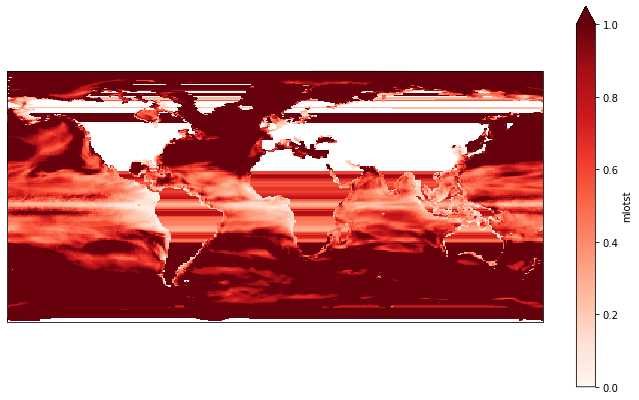

In [26]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
var_ungrid.plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=0,vmax=1, cmap='Reds')

In [7]:
test_mlotst_out = xe.util.grid_global(2,2, lon1=360)
test_mlotst_out

<xarray.Dataset>
Dimensions:  (y: 90, x: 180, y_b: 91, x_b: 181)
Coordinates:
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) float64 0.0 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0 360.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [8]:
regridder = xe.Regridder(test_mlotst, test_mlotst_out, "bilinear", ignore_degenerate=True)
test_regridded_out = regridder(test_mlotst["mlotst"])
test_regridded_out

<xarray.DataArray (time: 6000, y: 90, x: 180)>
dask.array<_regrid, shape=(6000, 90, 180), dtype=float32, chunksize=(468, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [9]:
test_regridded_out.to_dataset(name='ff')

<xarray.Dataset>
Dimensions:  (time: 6000, y: 90, x: 180)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x
Data variables:
    ff       (time, y, x) float32 dask.array<chunksize=(468, 90, 180), meta=np.ndarray>

In [13]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

rolling_test = test_regridded_out.rolling(time=300,center=True).mean('time')
variability_test = rolling_test.std('time')
fin = variability_test.to_dataset(name='mlotst') #Name of variable - mlotst
xin = nc_varget(fin,'lon');
yin = nc_varget(fin,'lat');
zin = nc_varget(fin,'mlotst');

x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

#new coordinates
xout = np.arange(x0,x1+dx,dx)
yout = np.arange(y0,y1+dx,dy)

xm,ym = np.meshgrid(xout,yout)
zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

final_test = xr.DataArray(zo, dims=['lat','lon'])
final_test.coords['lon'] = xout
final_test.coords['lat'] = yout

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


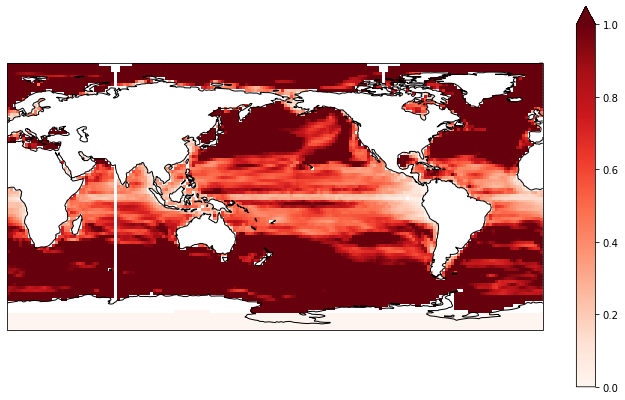

In [25]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
test_var.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

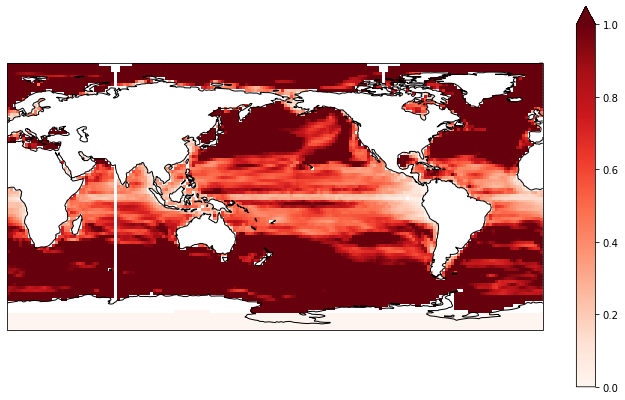

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
final_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

In [15]:
final_test

<xarray.DataArray (lat: 90, lon: 180)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.474138 , 1.4457155, 1.4242212, ..., 1.607038 , 1.55493  ,
        1.5098606],
       [1.5183147, 1.4902302, 1.4622576, ..., 1.6097026, 1.5777199,
        1.54751  ],
       [1.4292563, 1.4108605, 1.3928925, ..., 1.4841306, 1.4659888,
        1.4480423]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

In [30]:
final_test['lon'].ndim

1

In [26]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[0]
mapper = gcs.get_mapper(zstore)

test_mlotst2 = xr.open_zarr(mapper, consolidated=True)
test_mlotst2

<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, lat, lon) float32 dask.array<chunksize=(670, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    ...                     ...
    variable_id:            mlotst
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d9acf7e3-3970-44c5-bb0d-57ec2bc0c5ad...
    version_id:             v20180701

In [3]:
# From Ryan Abernathy's tutorial - Way 2
# Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]
    
dset_list_hml_control = []
for zstore in df_hml_control.zstore.unique():
    name = zstore.split('gs://cmip6/CMIP6')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
    ds_rolling = ds.mlotst.rolling(time=300, center=True).mean('time')
    ds_var = ds_rolling.std('time') 
    if ds['lat'].ndim == 1:
        try:
            ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        except:
            pass
    elif ds['lat'].ndim == 2:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

        ds_regrid = xr.DataArray(zo, dims=['lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
    dset_list_hml_control.append(ds_interp)

NameError: name 'df_hml_control' is not defined

In [36]:
dset_list_hml_control

[<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
   * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357,
 <xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
   * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357,
 <xarray.DataArray (lat: 88, lon: 179)>
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
  

In [37]:
test_hml_control_ds = xr.concat(dset_list_hml_control, dim='name', coords='minimal', compat='override')
control_hml_test = test_hml_control_ds.mean('name')
control_hml_test.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.81748616, 1.75880403, 1.76568958, ..., 2.31116948, 2.20852958,
        2.07267268],
       [1.76620979, 1.82313759, 1.94454538, ..., 1.89451852, 1.80844404,
        1.74998385],
       [3.44004033, 3.48039912, 3.48021962, ..., 3.11461802, 3.2288693 ,
        3.29381019]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

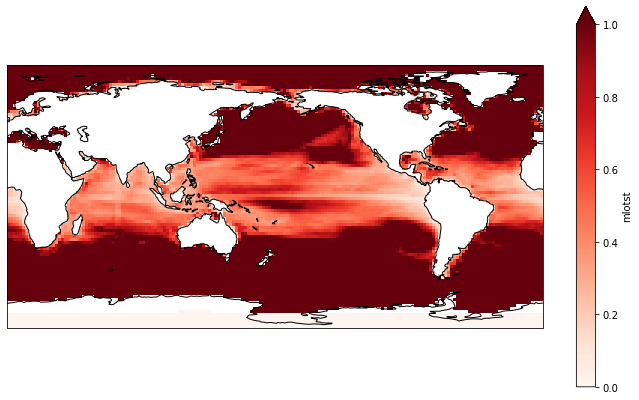

In [43]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_hml_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)